# Init

In [1]:
import cv2 as cv
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import skimage

In [2]:
sns.set(style='dark')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'viridis'
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

# Corner Detection

We have an input image $I$ of size $M \times N$. **Harris corner detector** does the following:
1. Compute image derivatives $I_x$ and $I_y$ in $x$ and $y$ directions, respectively, a.k.a. the gradient
   $$
   \nabla I = \begin{bmatrix}
       I_x \\
       I_y
   \end{bmatrix}
   $$
2. Compute a matrix
   $$
   \bold{D}
   = \nabla I \cdot (\nabla I)^\top
   = \begin{bmatrix}
       I_x^2         & I_x \cdot I_y \\
       I_y \cdot I_x & I_y^2
   \end{bmatrix}
   $$
   When implementing the detector, $\bold{D}$ could be a tensor of size $M \times N \times 2 \times 2$.
3. Compute an "autocorrelation" matrix $\bold{M}$ by convolving (smoothing) $\bold{D}$ with a discrete Gaussian window $g$
   $$
   \bold{M} = g * \bold{D} = g * \begin{bmatrix}
       I_x^2         & I_x \cdot I_y \\
       I_y \cdot I_x & I_y^2
   \end{bmatrix}
   = \begin{bmatrix}
       g * I_x^2         & g * (I_x \cdot I_y) \\
       g * (I_y \cdot I_x) & g * I_y^2
   \end{bmatrix}
   $$
   Similarly to $\bold{D}$, when implementing, $\bold{M}$ could be a tensor of size $M \times N \times 2 \times 2$.
4. For each pixel, compute a "corneress" measure
   $$
   R = \det(\bold{M}) - \alpha \cdot (\textrm{trace}(\bold{M}))^2
   $$
   Again, in an implementation, $R$ could be represented as a matrix of the same size as the input image $I$, i.e. $M \times N$. $\alpha$ is a hyperparameter, usually $\alpha \approx 0.04$.
5. Find local maxima in $R$. Each local maximum at position $(x,y)$ with corresponding value of $R(x,y) \gt t$ will be considered a corner.


https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html

In [3]:
def find_local_maxima(arr: np.ndarray, wnd_size: int = 3) -> np.ndarray:
    windows = np.lib.stride_tricks.sliding_window_view(
        np.pad(arr, wnd_size // 2, constant_values=arr.min() - 1),
        (wnd_size,) * arr.ndim
    )
    windows = windows.reshape(np.prod(arr.shape), -1)
    colmask = np.ones(windows.shape[1], dtype=bool)
    colmask[windows.shape[1] // 2] = False
    ismaxs = np.all(windows[:, ~colmask] > windows[:, colmask], axis=1)
    return np.hstack(np.unravel_index(np.argwhere(ismaxs), arr.shape))

In [4]:
def corner_harris(
        gray: np.ndarray,
        sigma: float = 3.,
        alpha: float = 0.04,
        threshold_rel: float = 0.01
) -> tuple[np.ndarray, np.ndarray]:
    # step 1 (gradient)
    dx = skimage.filters.sobel_v(gray)
    dy = skimage.filters.sobel_h(gray)

    # step 2
    dx2 = dx * dx
    dxdy = dx * dy
    dy2 = dy * dy

    # step 3 (smoothing)
    dx2 = scipy.ndimage.gaussian_filter(dx2, sigma)
    dxdy = scipy.ndimage.gaussian_filter(dxdy, sigma)
    dy2 = scipy.ndimage.gaussian_filter(dy2, sigma)

    # step 4 (harris corner measure)
    corneress = dx2 * dy2 - alpha * (dx2 + dy2) ** 2

    # step 5 (thresholding + non-max suppression)
    corneress_ = corneress.copy()
    corners = find_local_maxima(corneress)  # non-maximum suppression
    strong = corneress[corners[:, 0], corners[:, 1]] > threshold_rel * corneress.max()  # thresholding

    return corners[strong], corneress

In [5]:
rgb = skimage.io.imread('data/simple.jpg')
gray = skimage.color.rgb2gray(rgb)

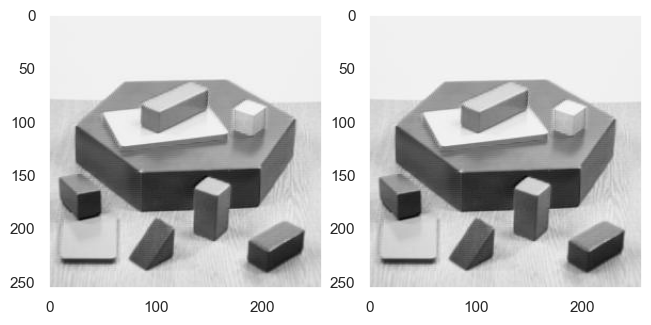

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb)
axes[1].imshow(gray, cmap='gray', vmin=0, vmax=1);

In [7]:
corners, corneress = corner_harris(gray, threshold_rel=0.1)
corners.shape

(41, 2)

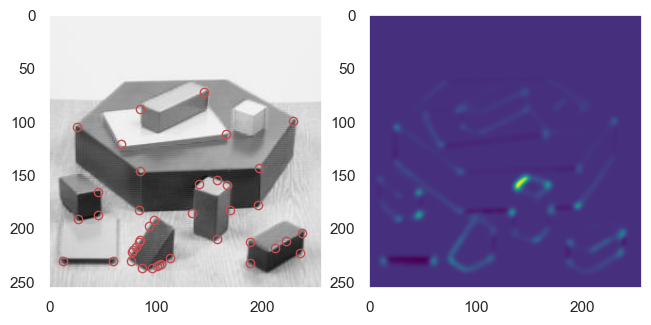

In [8]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb)
axes[0].plot(corners[:, 1], corners[:, 0], 'ro', mfc='none')
axes[1].imshow(corneress);

## Harris corner detection in scikit-image

In [9]:
corneress = skimage.feature.corner_harris(gray, method='k', k=0.04)
corneress.shape, corneress.dtype, corneress.min(), corneress.max()

((256, 256), dtype('float64'), -1.3002597693165436, 6.791911722239594)

In [10]:
corners = skimage.feature.corner_peaks(corneress, threshold_rel=0.01, min_distance=10)
corners.shape

(28, 2)

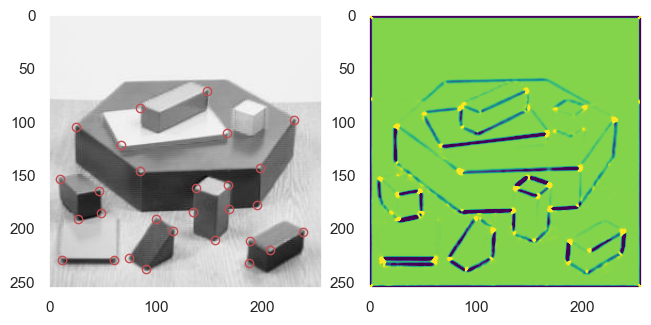

In [11]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb)
axes[0].plot(corners[:, 1], corners[:, 0], 'ro', mfc='none')
axes[1].imshow(corneress, vmin=np.percentile(corneress, 5), vmax=np.percentile(corneress, 99));

In [12]:
corners_subpix = skimage.feature.corner_subpix(gray, corners, alpha=0.7)
corners_subpix

array([[161.791, 135.888],
       [158.381, 170.082],
       [163.865,  47.997],
       [182.517, 135.478],
       [ 96.509, 230.698],
       [103.349,  24.538],
       [201.552, 239.097],
       [147.37 ,  85.28 ],
       [181.34 , 169.018],
       [211.268, 186.711],
       ...,
       [211.989, 155.009],
       [151.883,   8.769],
       [ 69.303, 148.587],
       [187.064,  48.444],
       [221.293, 206.644],
       [179.572, 195.736],
       [239.372,  90.833],
       [189.565,  99.764],
       [122.642,  66.748],
       [231.021, 185.542]])

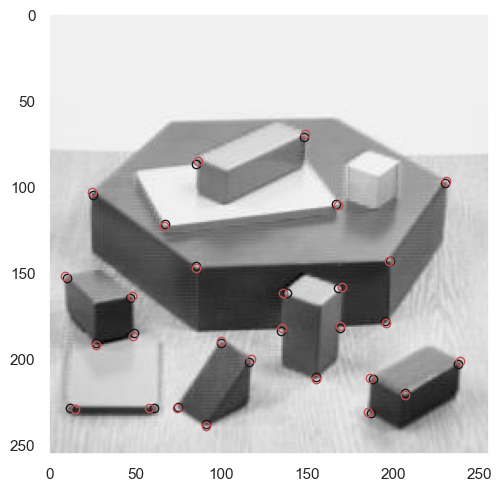

In [13]:
plt.imshow(rgb)
plt.plot(corners[:, 1], corners[:, 0], 'ko', mfc='none');
plt.plot(corners_subpix[:, 1], corners_subpix[:, 0], 'ro', mfc='none');

## Harris corner detector in OpenCV

https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

In [14]:
corneress = cv.cornerHarris(skimage.util.img_as_ubyte(gray), 2, 3, 0.04)
corneress.shape, corneress.dtype, corneress.min(), corneress.max()

((256, 256), dtype('float32'), -0.0040677125, 0.0018316489)

In [15]:
corners = np.argwhere(corneress > 0.01 * corneress.max())

In [16]:
corneress[corneress < 0.02 * corneress.max()] = 0.  # thresholding
corners = skimage.feature.peak_local_max(corneress)  # non-maximum suppression
corners.shape

(56, 2)

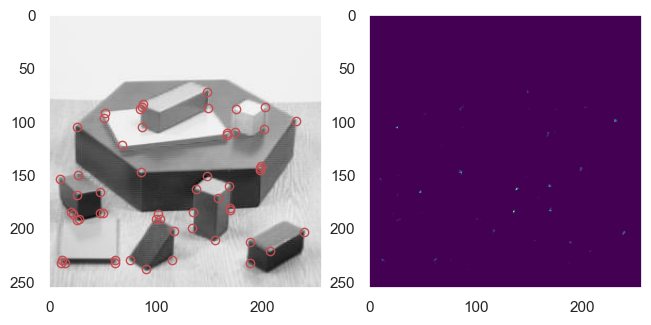

In [17]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb)
axes[0].plot(corners[:, 1], corners[:, 0], 'ro', mfc='none')
axes[1].imshow(corneress);

## Good Feautres to Track (GFTT)

Good Features To Track use by default Shi-Tomasi corner detection method, which computes slightly different metric of corneress
$$
R = \min(\lambda_1,\lambda_2)
$$
where $\lambda_1,\lambda_2$ are eigenvalues of the same auto-correlation matrix $\bold{M}$ as in Harris corner detector.

Good features to track add several other considerations to the method of detection, such as minimum distance between corners, relative thresholds of corneress quality etc.

https://docs.opencv.org/master/d4/d8c/tutorial_py_shi_tomasi.html

In [18]:
gftt = cv.GFTTDetector.create(qualityLevel=0.1, minDistance=15)
gftt

< cv2.GFTTDetector 000001FC1FC33730>

In [19]:
kpts = gftt.detect(rgb)
type(kpts), len(kpts)

(tuple, 40)

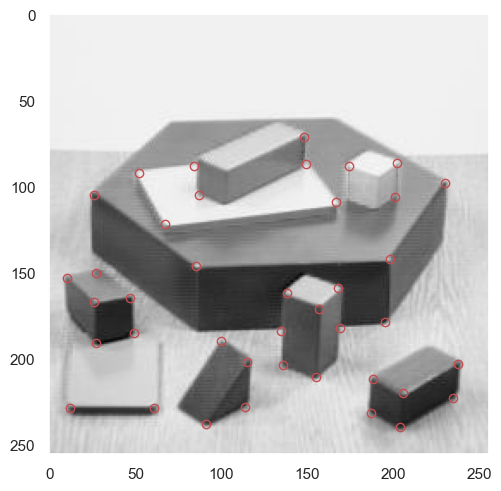

In [20]:
plt.imshow(rgb)
plt.plot([kp.pt[0] for kp in kpts], [kp.pt[1] for kp in kpts], 'ro', mfc='none');

# Blob detection

One particular method of blob detection is based on the normalized Laplacian of Gaussian (LoG) operator
$$
\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}
$$
We first compute a scale space, which is a repeated convolution of an image $I$ with a Gaussian kernel $g_\sigma$ of varying $\sigma$, i.e.
$$
L(x,y,\sigma) = g_\sigma(x,y) * I(x,y)
$$
The LoG operator is then applied to the scale space
$$
\nabla^2_\textrm{norm}L(x,y,\sigma) = \sigma^2 \cdot I(x,y) * \nabla^2g_\sigma
$$
Each local maximum $(x^*,y^*,\sigma^*)$ in $\nabla^2_\textrm{norm}L(x,y,\sigma)$ corresponds to a blob
- at position $(x^*,y^*)$
- and size proportional to $\sigma^*$

https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html

In [21]:
rgb = cv.imread('data/sunflowers.png')[..., ::-1]
gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)

In [22]:
plt.imshow(rgb);

In [23]:
log_blobs = skimage.feature.blob_log(1-gray, min_sigma=5., max_sigma=90., num_sigma=20, log_scale=True)  # 1-gray to detect dark blobs
log_blobs.dtype, log_blobs.shape

(dtype('float64'), (91, 3))

In [24]:
fig, ax = plt.subplots()
ax.imshow(rgb);
for y, x, s in log_blobs:
    c = plt.Circle((x, y), s, color=(1, 0, 1), linewidth=1, fill=False)
    ax.add_patch(c)

## Difference of Gaussians (DoG)

An approximation of LoG using simple subtraction of two blurred images.

In [25]:
level1_gray = cv.GaussianBlur(cv.cvtColor(rgb, cv.COLOR_RGB2GRAY), (21, 21), 4) / 255.
level2_gray = cv.GaussianBlur(cv.cvtColor(rgb, cv.COLOR_RGB2GRAY), (21, 21), 5) / 255.

In [26]:
fig, axes = plt.subplots(2, 1)
axes[0].imshow(level1_gray, cmap='gray', vmin=0, vmax=1)
axes[1].imshow(level2_gray, cmap='gray', vmin=0, vmax=1);

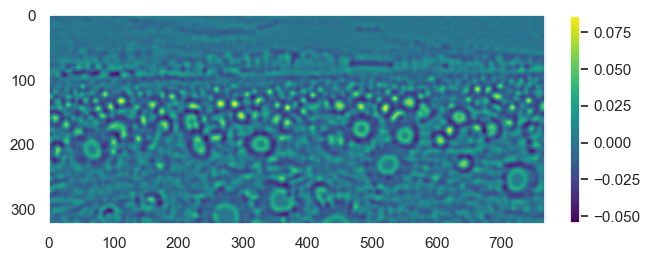

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(level2_gray - level1_gray)
fig.colorbar(im, ax=ax, shrink=0.44);

In [28]:
dog_blobs = skimage.feature.blob_dog(1. - gray, min_sigma=2., max_sigma=32., sigma_ratio=1.414, threshold=50)
dog_blobs.shape, dog_blobs.dtype

((185, 3), dtype('float64'))

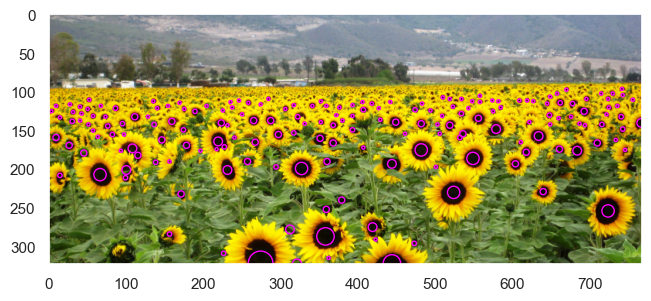

In [29]:
plt.imshow(rgb, cmap='gray', vmin=0, vmax=255)
for y, x, r in dog_blobs:
    plt.gca().add_patch(
        plt.Circle((x, y), r, color=(1, 0, 1), linewidth=1, fill=False)
    )

# Maximally Stable Extremal Regions (MSER)

Blob regions that barely change size when thresholding through a wide range of thresholds.

In [30]:
mser = cv.MSER.create()
mser

< cv2.MSER 000001FC1EBA0D70>

In [31]:
kpts = mser.detect(rgb)
type(kpts), len(kpts)

(tuple, 575)

In [32]:
plt.imshow(
    cv.drawKeypoints(rgb.copy(), kpts, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
);

In [33]:
msers, bboxes = mser.detectRegions(rgb)

In [34]:
    type(msers), len(msers)

(tuple, 585)

In [35]:
type(bboxes), bboxes.dtype, bboxes.shape

(numpy.ndarray, dtype('int32'), (585, 4))

In [36]:
label_image = np.zeros(gray.shape, dtype=np.int32)
for i, reg in enumerate(msers):
    label_image[reg[:, 1], reg[:, 0]] = i + 1

In [37]:
plt.imshow(label_image);

In [38]:
contours, _ = cv.findContours(label_image, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)

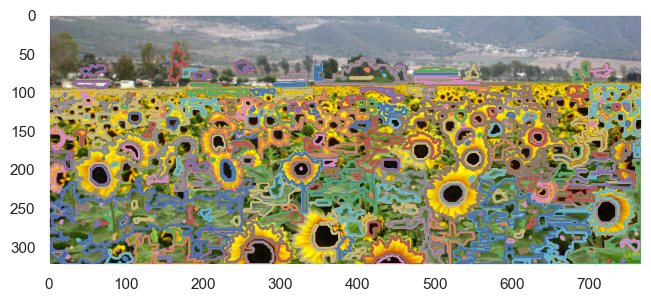

In [39]:
plt.imshow(rgb)
for ctr in contours:
    plt.plot(ctr[:, 0, 0], ctr[:, 0, 1], '-')
plt.xlim(0, rgb.shape[1])
plt.ylim(rgb.shape[0], 0);

# Local feature matching

https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

In [40]:
obj_rgb = cv.imread('data/box.png')[..., ::-1]
scn_rgb = cv.imread('data/box_in_scene.png')[..., ::-1]

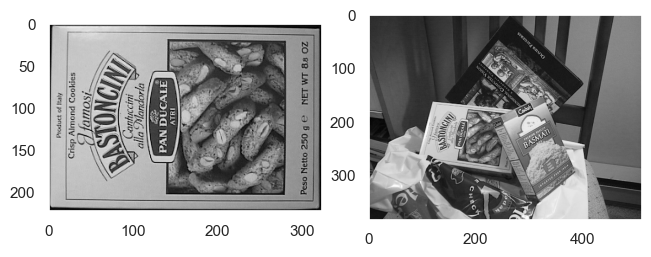

In [41]:
plt.subplot(1, 2, 1)
plt.imshow(obj_rgb)
plt.subplot(1, 2, 2)
plt.imshow(scn_rgb);

In [42]:
# create the detector object
detector = cv.SIFT_create()

In [43]:
# find the keypoints and descriptors from both images
obj_kpts, obj_des = detector.detectAndCompute(obj_rgb, None)
scn_kpts, scn_des = detector.detectAndCompute(scn_rgb, None)

In [44]:
type(obj_kpts), len(obj_kpts)

(tuple, 604)

In [45]:
type(obj_des), obj_des.dtype, obj_des.shape, obj_des.min(), obj_des.max()

(numpy.ndarray, dtype('float32'), (604, 128), 0.0, 216.0)

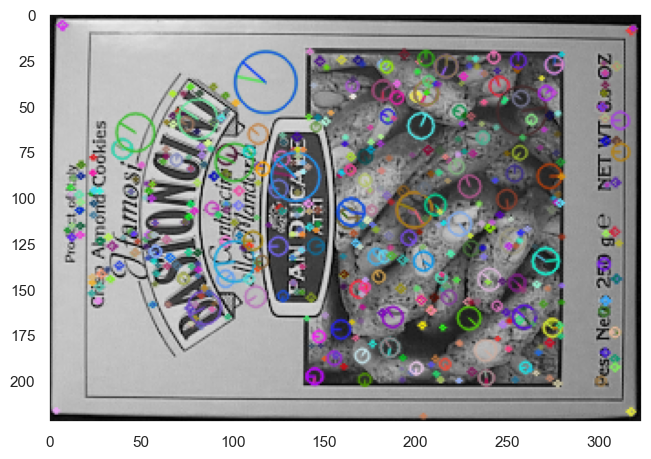

In [46]:
plt.imshow(
    cv.drawKeypoints(obj_rgb.copy(), obj_kpts, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
);

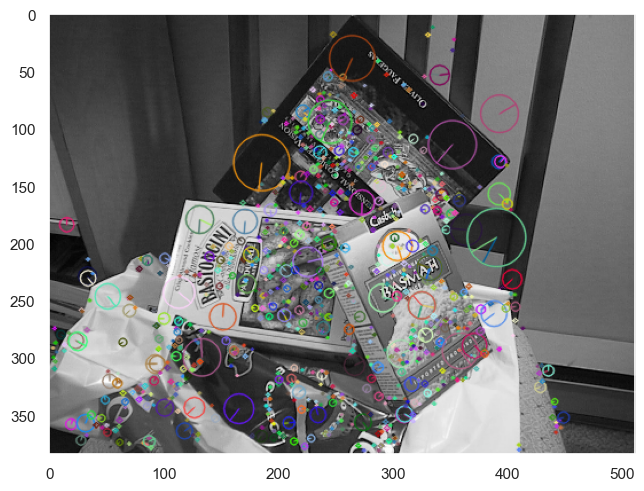

In [47]:
plt.imshow(
    cv.drawKeypoints(scn_rgb.copy(), scn_kpts, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
);

In [48]:
# remeber to use appropriate norm type
# e.g. when using binary descriptors such as ORB, use the Hamming norm instead of L2
matcher = cv.BFMatcher(cv.NORM_L2)
# matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

In [49]:
matches = matcher.knnMatch(scn_des, obj_des, k=2)
# matches = matcher.match(scn_des, obj_des)

In [50]:
type(matches), len(matches)

(tuple, 969)

In [51]:
matches[0]

(< cv2.DMatch 000001FC212F3DB0>, < cv2.DMatch 000001FC212F27B0>)

In [52]:
m = matches[0][0]
m.distance

397.5902404785156

In [53]:
m.distance, m.imgIdx, m.queryIdx, m.trainIdx

(397.5902404785156, 0, 0, 138)

In [54]:
# L2 distance (euclidean norm)
np.sqrt(np.sum((obj_des[m.trainIdx, :].astype(float) - scn_des[m.queryIdx, :].astype(float)) ** 2))

397.59024132893404

In [55]:
# Hamming distance (number of different values in binary representation of the descriptors)
# sum(
#     u != v
#     for q, t in zip(obj_des[m.trainIdx, :], scn_des[m.queryIdx, :])
#     for u, v in zip(f'{q:08b}', f'{t:08b}')
# )

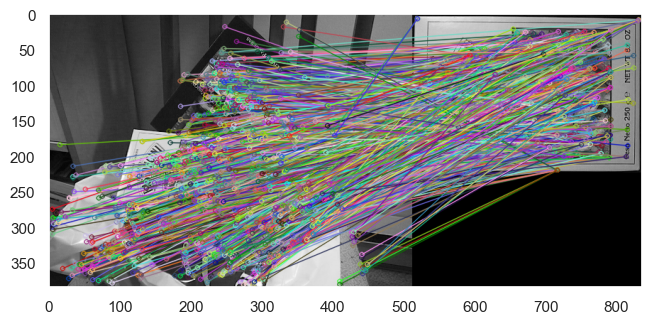

In [56]:
plt.imshow(
    cv.drawMatchesKnn(scn_rgb.copy(), scn_kpts, obj_rgb.copy(), obj_kpts, [[m] for m, n in matches], None, flags=2)
#     cv.drawMatchesKnn(obj_rgb.copy(), obj_kpts, scn_rgb.copy(), scn_kpts, [[m] for m in matches], None, flags=2)
);

In [57]:
# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good.append([m])

In [58]:
plt.imshow(
    cv.drawMatchesKnn(scn_rgb.copy(), scn_kpts, obj_rgb.copy(), obj_kpts, good, None, flags=2)
);

In [59]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary

In [60]:
flann = cv.FlannBasedMatcher(index_params, search_params)
fmatches = flann.knnMatch(scn_des, obj_des, k=2)

# Find the object in the image: homography estimation

In [61]:
src_pts = np.float32([obj_kpts[m[0].trainIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([scn_kpts[m[0].queryIdx].pt for m in good]).reshape(-1, 1, 2)

M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

In [62]:
M

array([[  0.441,  -0.163, 118.873],
       [ -0.   ,   0.405, 161.024],
       [ -0.   ,  -0.   ,   1.   ]])

In [63]:
h, w = obj_rgb.shape[:2]
pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2)
dst = cv.perspectiveTransform(pts, M).squeeze()

In [64]:
plt.imshow(scn_rgb)
plt.plot(dst[:, 0].tolist() + [dst[0, 0]], dst[:, 1].tolist() + [dst[0, 1]], '-r');